# Climate change sucks

In [2]:
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pennylane as qml
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

## Read in data

In [3]:

# Initialize empty lists to store data
prev_years = [[],[]]
final_years = [[],[]]

# Load temperature change data
with open('./data/Annual_Surface_Temperature_Change.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        temperature_data = [float(val) if val else 0.0 for val in row[35:-1]]
        final_temperature = float(row[-1]) if row[-1] else 0.0
        prev_years[0].append(temperature_data)
        final_years[0].append(final_temperature)

# Load total number of disasters data
with open("./data/disastors.csv", 'r', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t') 

    for row in csvreader:
        if row[4] == 'Total disasters' and row[5] == 'Number of':
            disasters_data = [float(val) if val else 0.0 for val in row[6:-1]]
            final_disasters = float(row[-1]) if row[-1] else 0.0
            prev_years[1].append(disasters_data)
            final_years[1].append(final_disasters)

# Convert the lists to PyTorch tensors
prev_years = torch.tensor(prev_years, dtype=torch.float64)
final_years = torch.tensor(final_years, dtype=torch.float64)

training_data = prev_years[:,:150,:]
test_data = prev_years[:,150:,:]

training_labels = final_years[:,:150]
test_labels = final_years[:,150:]

print("training data    ",training_data.shape)
print("test data        ",test_data.shape)
print("training labels  ",training_labels.shape)
print("test labels      ",test_labels.shape)

def normalise(data):
    max = torch.max(data)
    min = torch.min(data)
    data = (data - min)/(max-min)
    print(f"Normalised data, max={max}, min={min}")
    return data

training_data[0] = normalise(training_data[0])
training_data[1] = normalise(training_data[1])

test_data[0] = normalise(test_data[0])
test_data[1] = normalise(test_data[1])

training_labels[0] = normalise(training_labels[0])
training_labels[1] = normalise(training_labels[1])

test_labels[0] = normalise(test_labels[0])
test_labels[1] = normalise(test_labels[1])

training data     torch.Size([2, 150, 30])
test data         torch.Size([2, 50, 30])
training labels   torch.Size([2, 150])
test labels       torch.Size([2, 50])
Normalised data, max=3.691, min=-1.31
Normalised data, max=34.0, min=0.0
Normalised data, max=3.026, min=-1.12
Normalised data, max=43.0, min=0.0
Normalised data, max=2.929, min=-1.305
Normalised data, max=14.0, min=0.0
Normalised data, max=2.798, min=-0.49
Normalised data, max=25.0, min=0.0


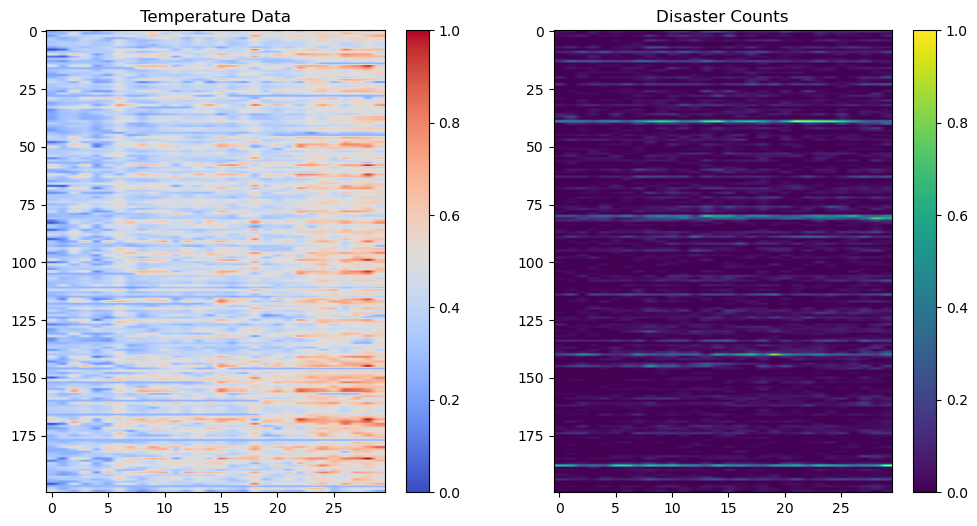

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize temperature data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(prev_years[0], cmap='coolwarm', aspect='auto')
plt.title('Temperature Data')
plt.colorbar()

# Visualize disaster counts
plt.subplot(1, 2, 2)
plt.imshow(prev_years[1], cmap='viridis', aspect='auto')
plt.title('Disaster Counts')
plt.colorbar()

plt.show()

## QNN with temperature and disasters data

In [6]:
# Define a quantum device
dev = qml.device("default.qubit", wires=10)
qreg = QuantumRegister(10)
creg = ClassicalRegister(10)
circuit = QuantumCircuit(qreg, creg)

def cost_function(x1, x2, training_labels, alpha, beta):
    x1 = torch.tensor(x1, requires_grad=True)
    x2 = torch.tensor(x2, requires_grad=True)
    
    temperature_distance = torch.norm(x1 - training_labels[0])
    disaster_distance = torch.norm(x2 - training_labels[1])

    loss = torch.sqrt(alpha * temperature_distance + beta * disaster_distance)
    return loss

# Define a VQC circuit using Pennylane
@qml.qnode(dev)

def quantum_circuit(x, params):
    for i in range(len(params)):
        qml.RY(params[i], wires=i)
    
    return [qml.expval(qml.PauliZ(i)) for i in range(10)]

def encode_value(qml, data, params):
    # Encode the fractional part (2 bits)
    frac_part = int((data) * 1000)
    bin_frac_part = format(frac_part, '02b')
    for i, bit in enumerate(bin_frac_part):
        if bit == '1':
            qml.x(qreg[i])  # Set the corresponding qubit to 1
    
    value = quantum_circuit(data, params)    
    return float(sum(value))/len(value)
                
# Define a Pennylane hybrid model that combines the quantum circuit and PyTorch model
class HybridModel(nn.Module):
    def __init__(self, input_size, num_qubits):
        super(HybridModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 16).to(torch.float64)
        self.fc2 = nn.Linear(16, 8).to(torch.float64)
        self.fc3 = nn.Linear(8, 1).to(torch.float64)

        # Initialize the trainable parameters for the VQC
        self.q_params = nn.Parameter(torch.randn(num_qubits), requires_grad=True)

    def forward(self, x):
        output = np.zeros(150)
        x1 = torch.relu(self.fc1(x))
        x2 = torch.relu(self.fc2(x1))
        x3 = self.fc3(x2)
        
        for country in range(len(x3)):
            quantum_output = torch.tensor(encode_value(circuit, x3[country], self.q_params))
            output[country] = x3[country] + quantum_output

        return output
    
input_size = 30

def train_and_test_model(alpha, beta, num_qubits):
    model = HybridModel(input_size, num_qubits)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    criterion = nn.MSELoss()

    model.train()
    optimizer.zero_grad()

    output_temp = model(training_data[0])
    output_dist = model(training_data[1])

    output_temp = torch.tensor(output_temp, requires_grad=True)
    output_dist = torch.tensor(output_dist, requires_grad=True)
    loss = cost_function(output_temp, output_dist, training_labels, alpha, beta)

    loss.backward()
    optimizer.step()
            
    optimizer_qparams = optim.Adam([model.q_params], lr=0.01)
    num_qparams_epochs = 10  
    for epoch in range(num_qparams_epochs):
        model.train()
        optimizer_qparams.zero_grad()

        output_temp = model(training_data[0])
        output_dist = model(training_data[1])

        loss = cost_function(output_temp[:], output_dist[:], training_labels, alpha, beta)
        loss.backward()
        optimizer_qparams.step()

    model.eval()
    cum_error = 0
    with torch.no_grad():
        test_input = test_data[0]
        predicted_output = model(test_input)
        
    for i in range(50):
        error = (predicted_output[i].item()-test_labels[0,i])**2
        cum_error += error

    print(f"MSE: {(cum_error)/50}")

In [ ]:
train_and_test_model(1.0,1.0,10)
train_and_test_model(1.0,0.5,10)
train_and_test_model(0.5,1.0,10)
train_and_test_model(0.0,0.0,10)